# Init model and params

In [1]:
import matplotlib.pyplot as plt
import sys, random
import numpy as np
import torch
from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample
from isegm.inference.predictors import get_predictor
from isegm.inference.clicker import Clicker
EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49
TARGET_IOU = 0.95

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = exp.load_config_file('./config.yml', return_edict=True)
checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'coco_lvis_h18_itermask')
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)



# Gen a click and make prediction

In [2]:
# selct a random image from dataset
DATASET = 'GrabCut'
dataset = utils.get_dataset(DATASET, cfg)
sample_id = random.sample(range(len(dataset)), 1)[0]
sample = dataset.get_sample(sample_id)
gt_mask = sample.gt_mask
predictor.original_image = None

In [3]:
# init mouse click
clicker = Clicker(gt_mask=gt_mask)
pred_mask = np.zeros_like(gt_mask)
prev_prediction = None
ious_list = []

[0.9270531598058015, 0.9753256487652695]


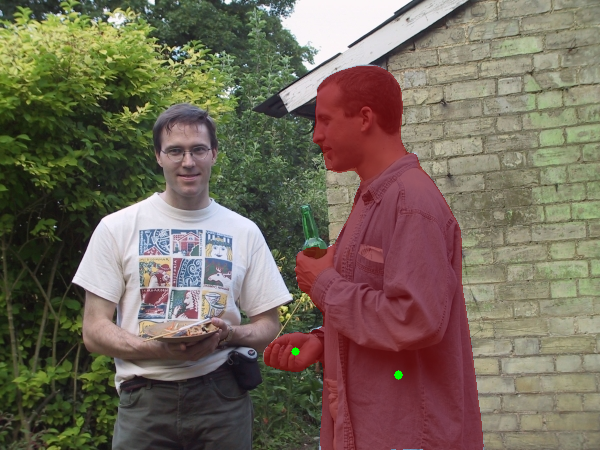

In [12]:
## run this block many times for continuous prediction
# gen a click and make prediction
clicker.make_next_click(pred_mask)

# get prediction
with torch.no_grad():
    img = sample.image
    predictor.set_input_image(img)
    pred_probs = predictor.get_prediction(clicker, prev_prediction)

# post precessing
prev_prediction = predictor.prev_prediction
pred_mask = pred_probs > MODEL_THRESH
iou = utils.get_iou(gt_mask, pred_mask)
ious_list.append(iou)
print(ious_list)

# draw prediction
from PIL import Image
draw = vis.draw_with_blend_and_clicks(sample.image, mask=pred_mask, clicks_list=clicker.clicks_list)
# plt.figure(figsize=(20,20))
# plt.imshow(draw)
# plt.show()
Image.fromarray(draw)
